In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


In [3]:
# Hyperparameters
input_size = 28 * 28  # MNIST images are 28x28 pixels
batch_size = 64
hidden_size = 256
hidden_size_2 = 256
num_classes = 10
dropout_rate = 0.3
num_epochs = 25
learning_rate = 0.001


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

print("Num of train Dataset: ",len(train_dataset),"|\tNum of test Dataset: ",len(test_dataset))

Num of train Dataset:  60000 |	Num of test Dataset:  10000


In [5]:
# Split the train set into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
from torch.utils.tensorboard import SummaryWriter
# TensorBoard setup
writer = SummaryWriter('./runs/logs/')

In [9]:
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear):
        # Xavier 초기화 (tanh에 적합)
        init.xavier_uniform_(m.weight)
        
        # He 초기화 (ReLU에 적합)
        # init.kaiming_uniform_(m.weight, nonlinearity='relu')
        # if m.bias is not None:
        #    init.zeros_(m.bias)

In [10]:
model = MLP(input_size, hidden_size, num_classes, dropout_rate)
model.to(device)

# Model summary
from torchsummary import summary
summary(model, (1, 28 * 28))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
           Sigmoid-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                   [-1, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


In [11]:
# Retrieve middle layer weight and bias shapes
fc1_weight_shape = model.fc1.weight.shape
fc1_bias_shape = model.fc1.bias.shape
print(f'FC1 Weight Shape: {fc1_weight_shape}, FC1 Bias Shape: {fc1_bias_shape}')

FC1 Weight Shape: torch.Size([256, 784]), FC1 Bias Shape: torch.Size([256])


In [12]:
# Helper function to visualize images in TensorBoard
def images_to_tensorboard(writer, images, labels, preds=None, step=0, name="Images"):
    img_grid = torchvision.utils.make_grid(images)
    writer.add_image(name, img_grid, global_step=step)
    if preds is not None:
        print(f"Predicted labels: {preds}")
        writer.add_text(f'{name}_Predictions', str(preds.tolist()), step)

In [13]:
# Track the best model
best_val_acc = 0
best_model = None

# Training loop
for epoch in range(num_epochs):
    model.train()   #gradient 변경
                    #eval 모드에서는 가중치 변경 x
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()   # 가중치 초기화
        loss.backward()         # 가중치 업데이트
        optimizer.step()

        # Track statistics : 중간 점검
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        #Add a few random images to TensorBoard along with their labels (every 100 steps)
        if i % 100 == 0:
            images_to_tensorboard(writer, images, labels, step=epoch * len(train_loader) + i)

    train_acc = 100 * correct / total
    val_acc = 0
    val_loss = 0.0
    total = 0
    correct = 0

    # Validation step
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    val_acc = 100 * correct / total

    # Log to TensorBoard  
    writer.add_scalar('Loss/train', running_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss / len(val_loader), epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)
    
    if (epoch%5 == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()

# Save the best model
torch.save(best_model, 'best_mlp_model.pth')
writer.close()

Epoch [1/25], Train Loss: 0.4983, Train Acc: 86.26%, Val Acc: 91.52%
Epoch [6/25], Train Loss: 0.1301, Train Acc: 96.22%, Val Acc: 96.33%
Epoch [11/25], Train Loss: 0.0840, Train Acc: 97.40%, Val Acc: 96.97%
Epoch [16/25], Train Loss: 0.0659, Train Acc: 98.00%, Val Acc: 97.34%
Epoch [21/25], Train Loss: 0.0547, Train Acc: 98.26%, Val Acc: 97.44%


In [14]:
# Test the model
model.load_state_dict(torch.load('best_mlp_model.pth'))
model.eval()
model.to('cpu')
correct = 0
total = 0
all_preds = []
all_labels = []
test_images = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())
        test_images.append(images)

test_acc = 100 * correct / total
print(f'Test Accuracy: {test_acc:.2f}%')


/tmp/ipykernel_1870215/3045129069.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mlp_model.pth'))


Test Accuracy: 97.83%


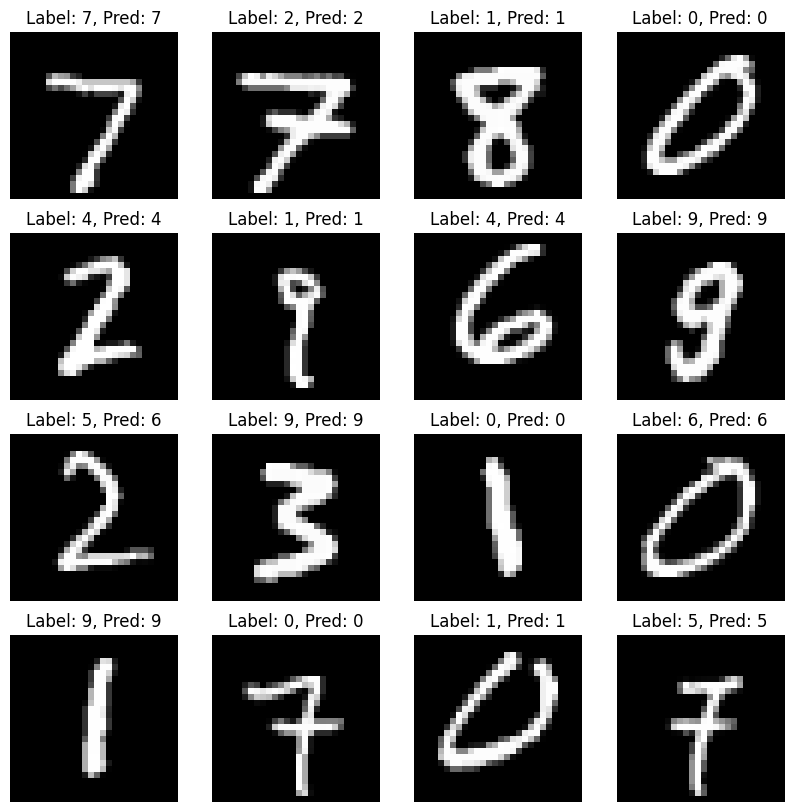

In [15]:
def visualize_predictions(images, labels, preds):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = images[i].squeeze().numpy()
        img = img[0]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {labels[i]}, Pred: {preds[i]}')
        ax.axis('off')
    plt.show()

test_images = test_images[:16]
test_labels = all_labels[:16]
test_preds = all_preds[:16]

visualize_predictions(test_images, test_labels, test_preds)

# Confusion Matrix

실제 데이터가 어떤 추정 값으로 분류되었는지 보여줌

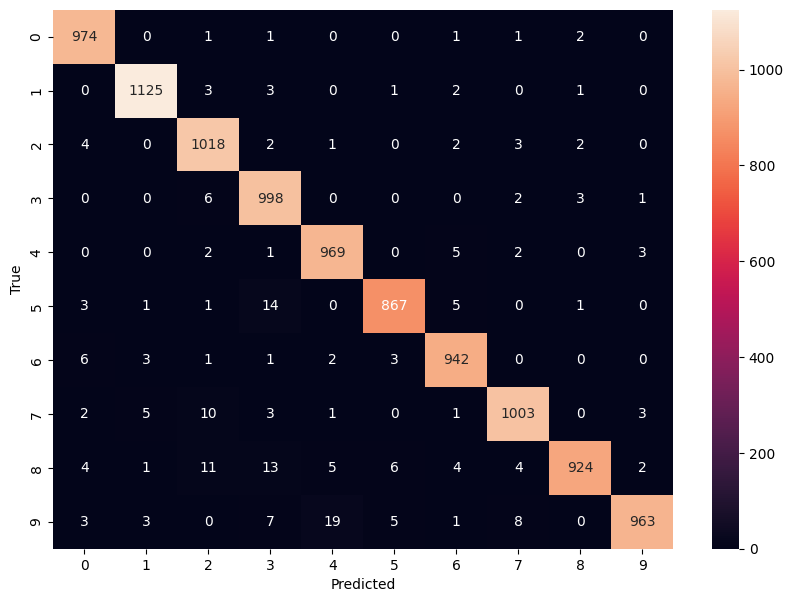

In [16]:
# Confusion matrix visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Close TensorBoard writer


In [17]:
!taskkill /F /PID 8856

/bin/bash: taskkill: command not found


In [18]:
%load_ext tensorboard
%tensorboard --logdir './runs/logs' --port 6006

Reusing TensorBoard on port 6006 (pid 1687998), started 7 days, 15:50:16 ago. (Use '!kill 1687998' to kill it.)

# 과제
- L2 정규화
- 배치 수 조절
- dropout

*Linear learning만 사용

-> 정확도 개선
--> 비교 리포트 제출